In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [2]:
def create_cmap(color1, color2, color3):
    colors = [color1, color2, color3]
    cmap_name = 'list'
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return cmap

def lorenz(t, state, par): 
    σ, ρ, β = par
    x, y, z = state
    ẋ = σ * (y - x)
    ẏ = (x * (ρ - z)) - y
    ż = (x * y) - (β * z)
    dx = np.array((ẋ, ẏ, ż))
    return dx

def get_lorenz_data(tspan):
    σ, ρ, β = 10, 28, 8 / 3 # chaotic parameters 
    initial = np.array([-8, 8, 27]) # initial condition 
    data = np.empty((3, len(tspan)))
    data[:, 0] = initial
    r = ode(lorenz).set_integrator('dopri5')
    r.set_initial_value(initial, tspan[0])
    r.set_f_params((σ, ρ, β))
    for i, t in enumerate(tspan):
        if i == 0:
            continue
        r.integrate(t)
        data[:, i] = r.y
    return data 

def build_hankel(data, rows, cols):
    X = np.empty((rows, cols))
    for k in range(rows):
        X[k, :] = data[k:cols + k]
    return X 

def HAVOK(X, dt, r, norm, center=False, return_uv=False):
    if (center): 
        m = X.shape[0]
        X̄ = X - X[m//2,:]
        U, Σ, Vh = np.linalg.svd(X̄,full_matrices=False)
    else:
        U, Σ, Vh = np.linalg.svd(X,full_matrices=False)
    V = Vh.T
    polys = true_polys(X.shape[0], dt, r, center)
    for _i in range(r):
        if (np.dot(U[:,_i], polys[:,_i]) < 0):
            U[:,_i] *= -1
            V[:,_i] *= -1
    V1 = V[:-1,:r]
    V2 = V[1:,:r]
    A = (V2.T @ np.linalg.pinv(V1.T) - np.eye(r)) / (norm * dt)
    if (return_uv): 
        return A, U, V
    return A

def true_polys(rows, dt, r, center): 
    m = rows // 2
    Ut = np.linspace(-m*dt, m*dt, rows)
    poly_stack = []
    for j in range(r):
        if (center):
            poly_stack.append(Ut ** (j + 1))
        else: 
            poly_stack.append(Ut ** j)
    poly_stack = np.vstack(poly_stack).T
    Q = np.empty((rows, r)) # Perform Gram-Schmidt
    for j in range(r): 
        v = poly_stack[:, j]
        for k in range(j - 1): 
            r_jk = Q[:, k].T @ poly_stack[:, j]
            v -= (r_jk * Q[:, k])
        r_jj = np.linalg.norm(v)
        Q[:, j] = v / r_jj
    return Q

# Increasing Sampling Frequency

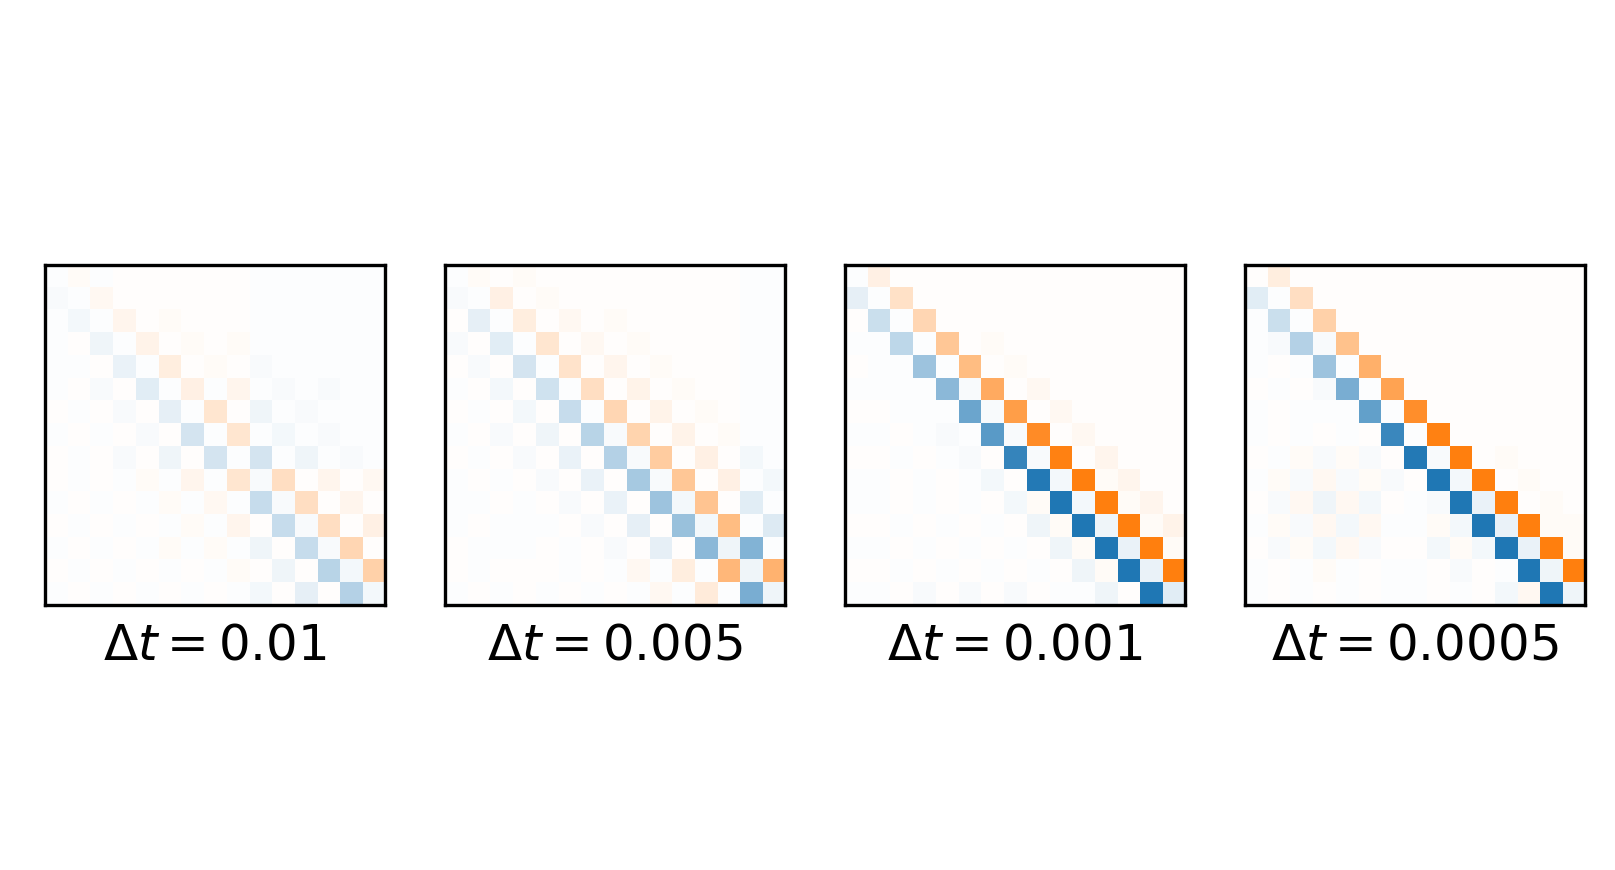

In [3]:
rows = 201 
cols = 20001

A = []
dt_vals = np.array([0.0005, 0.001, 0.005, 0.01])
for k,dt in enumerate(dt_vals):
    tmin = 0.0
    tmax = dt * (rows + cols - 2)
    tspan = np.arange(tmin, tmax + dt, dt)
    data = get_lorenz_data(tspan)
    xdata = data[0, :]
    X = build_hankel(xdata,rows,cols)
    A.append(HAVOK(X, dt, 15, 1))

# Plot results 
fig, ax = plt.subplots(sharex=True, figsize=(5.5, 3),dpi=300)
ax.axis('off')
vmin = -40
vmax = 40
cmap = create_cmap('tab:blue', 'white', 'tab:orange')

# dt = 0.01
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(A[3], vmin=vmin, vmax=vmax, cmap=cmap)
ax1.set_xlabel(r'$\Delta t=$'+ str(dt_vals[3]), fontsize=12)
plt.xticks([])
plt.yticks([])

# dt = 0.005
ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(A[2], vmin=vmin, vmax=vmax, cmap=cmap)
ax2.set_xlabel(r'$\Delta t=$'+ str(dt_vals[2]), fontsize=12)
plt.xticks([])
plt.yticks([])

# dt = 0.001
ax3 = fig.add_subplot(1, 4, 3)
im3 = ax3.imshow(A[1], vmin=vmin, vmax=vmax, cmap=cmap)
ax3.set_xlabel(r'$\Delta t=$'+ str(dt_vals[1]), fontsize=12)
plt.xticks([])
plt.yticks([])

# dt = 0.0005
ax4 = fig.add_subplot(1, 4, 4)
im4 = ax4.imshow(A[0], vmin=vmin, vmax=vmax, cmap=cmap)
ax4.set_xlabel(r'$\Delta t=$'+ str(dt_vals[0]), fontsize=12)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('pdf_files/fig5a.pdf',bbox_inches = "tight")

# Increasing Number of Data Columns 

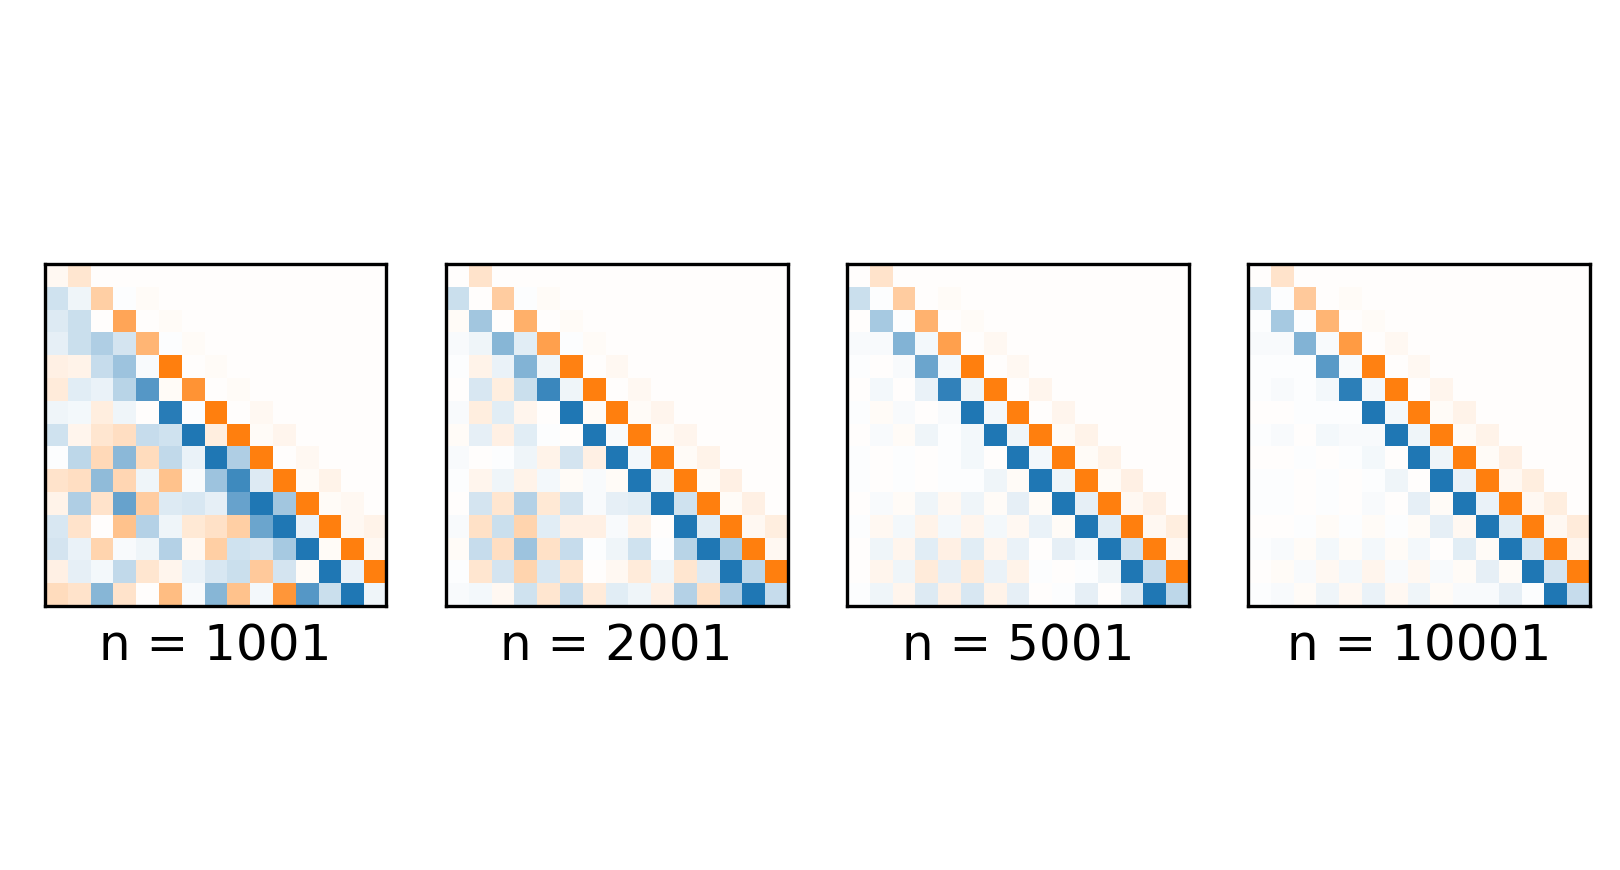

In [4]:
rows = 201
dt = 0.001 

A = []
n = []
sample_vals = np.array([1201, 2201, 5201, 10201])
for k,samples in enumerate(sample_vals):
    tspan = np.arange(samples) * dt
    data = get_lorenz_data(tspan)
    xdata = data[0, :]
    cols = xdata.size - rows + 1
    X = build_hankel(xdata,rows,cols)
    A.append(HAVOK(X, dt, 15, 1))
    n.append(cols)
    
# Plot results
fig, ax = plt.subplots(sharex=True, figsize=(5.5, 3),dpi=300)
ax.axis('off')
vmin = -22
vmax = 22
cmap = create_cmap('tab:blue', 'white', 'tab:orange')

# n = 1001
ax1 = fig.add_subplot(1, 4, 1)
im1 = ax1.imshow(A[0], vmin=vmin, vmax=vmax, cmap=cmap)
ax1.set_xlabel('n = {}'.format(n[0]), fontsize=12)
plt.xticks([])
plt.yticks([])

# n = 2001
ax2 = fig.add_subplot(1, 4, 2)
im2 = ax2.imshow(A[1], vmin=vmin, vmax=vmax, cmap=cmap)
ax2.set_xlabel('n = {}'.format(n[1]), fontsize=12)
plt.xticks([])
plt.yticks([])

# n = 5001
ax3 = fig.add_subplot(1, 4, 3)
im3 = ax3.imshow(A[2], vmin=vmin, vmax=vmax, cmap=cmap)
ax3.set_xlabel('n = {}'.format(n[2]), fontsize=12)
plt.xticks([])
plt.yticks([])

# n = 10001
ax4 = fig.add_subplot(1, 4, 4)
im4 = ax4.imshow(A[3], vmin=vmin, vmax=vmax, cmap=cmap)
ax4.set_xlabel('n = {}'.format(n[3]), fontsize=12)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('pdf_files/fig5b.pdf',bbox_inches = "tight")